In [2]:
# Sitting up the environnement
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

Loading data

In [3]:
site_traffic_df = pd.read_csv("../recipe_site_traffic.csv")
site_traffic_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN
...,...,...,...,...,...,...,...,...
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,NaN
943,944,NaN,NaN,NaN,NaN,Potato,2,High
944,945,951.74,29.42,3.57,13.87,Pork,2,High
945,946,266.61,35.77,0.97,8.07,Potato,6,High


Data info

In [4]:
site_traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


First things first, we can see that there is some data missing in calories, carbohydrate, sugar, protein and high_traffic columns. Second, category, servings and high_traffic columns are pandas objects, which means that they are categorical.
According to the product manager 'servings' must be numerical so let's start with converting it to numeric.

1. ## Data Preprocessing

#### Dealing with "servings" column

Converting servings to integers as required

In [5]:
site_traffic_df['servings'].unique()

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

As we can see, there are some elements in the servings column that must be processed in the form of {integer+"as a snack"}.

In [6]:
site_traffic_df['servings'] = pd.to_numeric(site_traffic_df['servings'].str.split().str[0], errors='coerce')

Let's check if the column's data type has changed to numerical (integer)

In [7]:
site_traffic_df['servings'].dtype

dtype('int64')

Okay, moving on..

#### Dealing with "category" column

What categories we have ?

In [8]:
category_list = list(site_traffic_df['category'].unique())
print(category_list, "\nN°categories =",len(category_list))

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert'] 
N°categories = 11


Comparing with the list provided by the manager

In [9]:
managers_category_list = ['Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken', 'Pork', 'Dessert', 'Breakfast','One Dish Meal']
for cat in category_list:
    if cat not in managers_category_list:
        print(cat)

Chicken Breast


We can classify 'Chicken Breast' with the 'Chicken' category

In [10]:
site_traffic_df['category'] = site_traffic_df['category'].str.replace('Chicken Breast','Chicken')

Let's check now if we have the same categories as the manager's

In [11]:
print(site_traffic_df['category'].unique())
print(site_traffic_df['category'].unique().shape)

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken'
 'Lunch/Snacks' 'Vegetable' 'Meat' 'Dessert']
(10,)


Great ! Moving on..

#### Dealing with "high_trafic" column

We only have 'High' traffic or null values in this column

In [12]:
site_traffic_df['high_traffic'].unique()

array(['High', nan], dtype=object)

In [13]:
missing_high_traffic = site_traffic_df['high_traffic'].isnull().sum()
missing_high_traffic

373

In [14]:
ratio = missing_high_traffic/len(site_traffic_df['high_traffic'])
ratio*100

39.38753959873284

About 39% of the data is missing in the 'high_traffic' column. At this stage we cannot define null values as 'High' or 'Not High' simply because the recipes aren't shown on the site yet (or shown but no high traffic was observed and no data was delivered, let's just call it unknown). Having a set of recipes we will be predicting the ones that lead to high traffic.

In [15]:
site_traffic_df['high_traffic'] = site_traffic_df['high_traffic'].fillna('unknown')
site_traffic_df['high_traffic'].sample(10)

588       High
436       High
322       High
354       High
185       High
17        High
276       High
507    unknown
778       High
739       High
Name: high_traffic, dtype: object

#### Dealing with missing values

For the rows that have null values for 'calories', 'carbohydrate', 'sugar' and 'protein' at once, it is better to drop them simply because without them we cannot define a recipe (and setting them to 0 or mean of data is not relevant).

In [16]:
columns_of_interest = ['calories', 'carbohydrate', 'sugar', 'protein']
missing_values_df = site_traffic_df[site_traffic_df[columns_of_interest].isnull().all(axis=1)]
missing_values_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
851,852,NaN,NaN,NaN,NaN,Lunch/Snacks,4,High
0,1,NaN,NaN,NaN,NaN,Pork,6,High
865,866,NaN,NaN,NaN,NaN,Lunch/Snacks,6,High
555,556,NaN,NaN,NaN,NaN,Meat,2,unknown
23,24,NaN,NaN,NaN,NaN,Meat,2,unknown
896,897,NaN,NaN,NaN,NaN,Chicken,6,High
48,49,NaN,NaN,NaN,NaN,Chicken,4,unknown
388,389,NaN,NaN,NaN,NaN,Lunch/Snacks,4,High
455,456,NaN,NaN,NaN,NaN,Pork,6,High
354,355,NaN,NaN,NaN,NaN,Pork,4,High


We count 52 observations where 'calories', 'carbohydrate', 'sugar' and 'protein' columns all have null values at once. 52+895=947 which is the length of our dataset. Now we can drop the corresponding rows and we're sure that we're dropping only rows where we have null values for the four items.

In [17]:
site_traffic_df_cleaned = site_traffic_df.copy()
site_traffic_df_cleaned = site_traffic_df_cleaned.dropna(subset=columns_of_interest, how='all')
site_traffic_df_cleaned.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
737,738,686.84,17.72,95.75,1.64,Dessert,4,High
932,933,1017.32,85.12,1.71,1.85,Potato,1,unknown
228,229,0.14,18.12,11.15,87.34,Lunch/Snacks,2,High
225,226,133.80,5.48,0.44,57.76,Pork,6,High
829,830,912.77,79.94,1.85,44.36,One Dish Meal,1,High
177,178,114.00,113.65,3.10,26.36,Lunch/Snacks,4,unknown
229,230,393.73,39.26,1.33,17.38,Chicken,1,unknown
266,267,436.03,7.66,22.30,23.03,Meat,4,High
477,478,28.33,66.30,0.77,10.13,Lunch/Snacks,6,unknown
908,909,109.42,51.67,2.54,4.50,Lunch/Snacks,1,High


In [18]:
site_traffic_df_cleaned['high_traffic'].value_counts()

high_traffic
High       535
unknown    360
Name: count, dtype: int64

Now that we have a clean dataset, let's explore it !

2. ## Data Exploration

#### Dataset Description

In [19]:
site_traffic_df_cleaned.describe()

,recipe,calories,carbohydrate,sugar,protein,servings
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,473.652514,435.939196,35.069676,9.046547,24.149296,3.458101
std,272.763283,453.020997,43.949032,14.679176,36.369739,1.735979
min,2.000000,0.140000,0.030000,0.010000,0.000000,1.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000,2.000000
50%,475.000000,288.550000,21.480000,4.550000,10.800000,4.000000
75%,708.500000,597.650000,44.965000,9.800000,30.200000,4.000000
max,947.000000,3633.160000,530.420000,148.750000,363.360000,6.000000


Interquartile Range (IQR)

In [20]:
iqr = site_traffic_df_cleaned['calories'].quantile(0.75) - site_traffic_df_cleaned['calories'].quantile(0.25)
# just checking if we have the same quantiles in the description table
print("First Quantile:", site_traffic_df_cleaned['calories'].quantile(0.25), "Third Quantile", site_traffic_df_cleaned['calories'].quantile(0.75))
# Interquantile Range
print("IQR =", iqr)

First Quantile: 110.43 Third Quantile 597.65
IQR = 487.21999999999997


While the columns for 'recipe' and 'servings' may offer limited insight, the remaining columns in the dataset provide more substantial information for analysis.
I can read the results but the table is more insightful.
Let me analyze the 'calories' for you :
- Skewness: The median (288.55) being less than the mean (435.94) suggests a positively skewed distribution. This skewness is further indicated by the fact that the IQR (487.22) is larger than the mean.
- Variability: The large difference between the IQR and the median indicates substantial variability in the middle 50% of the dataset.
- Outliers: The large difference between the mean and the median, as well as the large IQR, suggest the possible presence of outliers on the higher end of the distribution. These outliers are likely influencing the mean and contributing to the positively skewed distribution.
- Central Tendency: The fact that the median is substantially lower than the mean indicates that the distribution is heavily influenced by the higher values, pulling the mean upwards. In this case, the median may be a more representative measure of central tendency, especially in the presence of outliers.

#### Some visualizations

To validate the previous interpretations let's visualize data.

<Axes: ylabel='calories'>

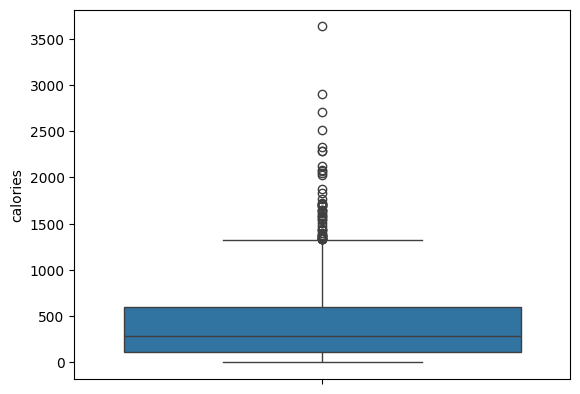

In [21]:
sns.boxplot(data=site_traffic_df_cleaned['calories'])

Most of 'calories' data is concentrated in the range [100,600]. Here we can observe the presence of outliers that can affect our analysis but we have a great solution for this which is data normalization, so let's not worry about this.

[]

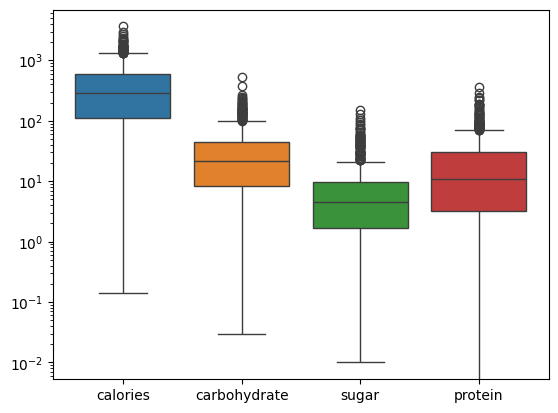

In [22]:
recipes_cols = site_traffic_df_cleaned.columns[1:-2]
sns.boxplot(data=site_traffic_df_cleaned[recipes_cols])
plt.semilogy()

We can see the presence of outliers also for the other items (recipe and servings are not representative).

Now let's verify the distribution skewness of 'calories'

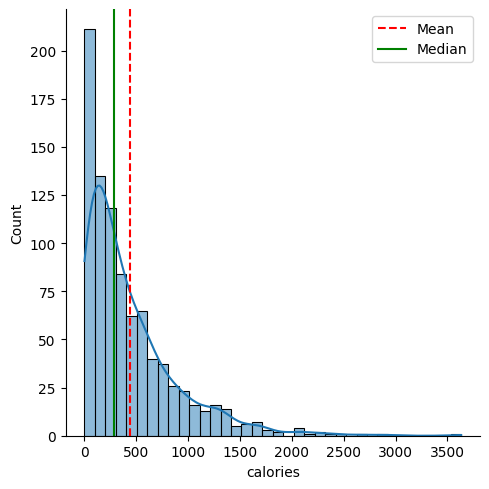

In [23]:
# plotting calories distribution
sns.displot(site_traffic_df_cleaned['calories'], kde='true')

# vertical line at the mean
plt.axvline(site_traffic_df_cleaned['calories'].mean(), color='r', linestyle='--', label='Mean')

# vertical line at the median
plt.axvline(site_traffic_df_cleaned['calories'].median(), color='g', linestyle='-', label='Median')

# legend
plt.legend()

# display
plt.show()

In [24]:
# skewness calculation
skewness = site_traffic_df_cleaned['calories'].skew()
print("Skewness:", skewness)

Skewness: 2.036150959685193


The value of skewness is greater than 1, this distribution is highly skewed to the right.

#### Relationship between two variables

Out of curiosity, let's plot the correlation matrix of recipes.

In [28]:
# correlation_matrix = site_traffic_df_cleaned[recipes_cols].corr()

# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt=".3f", linewidths=0.5)
# plt.title('Correlation Matrix')
# plt.show()

In this matrix we can see if we have positive or negative correlation between two variables (calories vs protein, sugar vs carbohydrate, sugar vs calories, etc.), it is important to note that this doesn't prove any relationship between these variables because one variable (calories for example) can depend on all the other variables and not only one.

Now a pairplot to see the distribution of each item

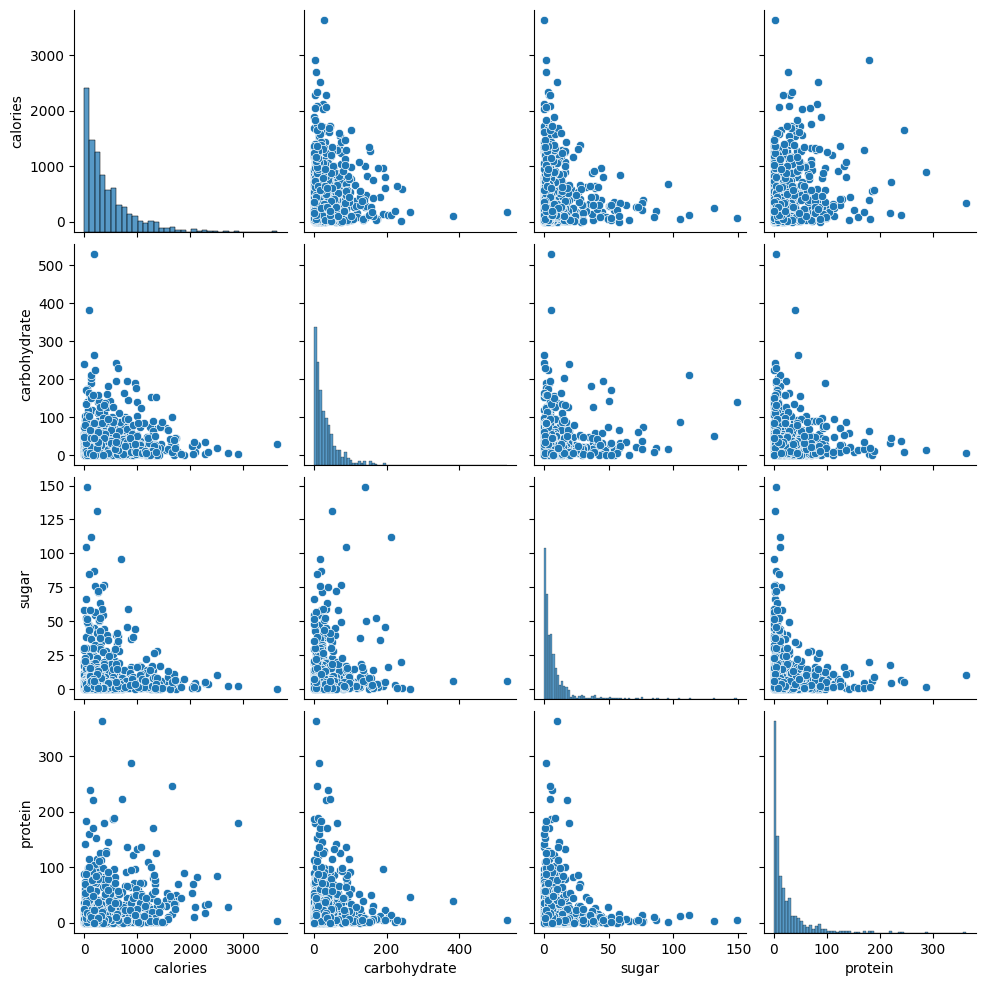

In [29]:
sns.pairplot(site_traffic_df_cleaned[recipes_cols])

#### Relationship between calories and category

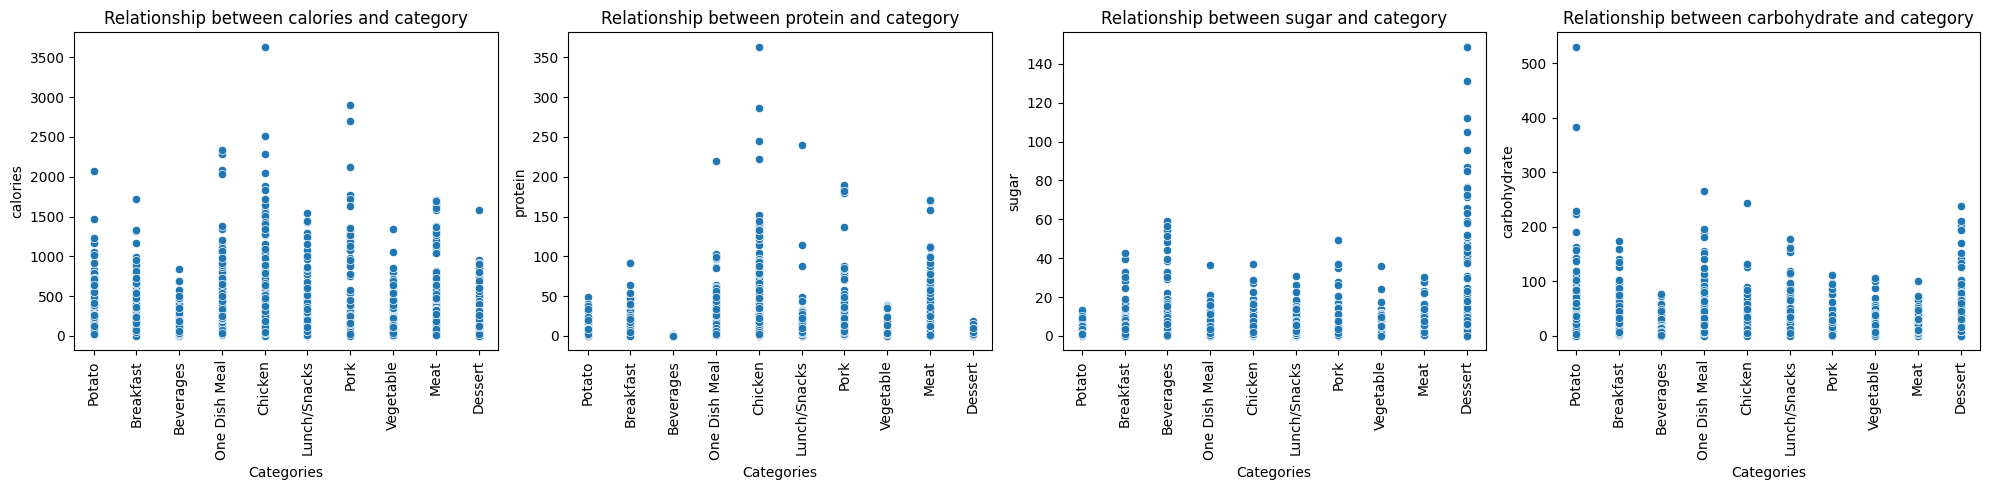

In [30]:
columns_to_plot = site_traffic_df_cleaned[['calories', 'protein', 'sugar', 'carbohydrate']]

# figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# scatter plot in a separate subplot
for i, col in enumerate(columns_to_plot):
    sns.scatterplot(x=site_traffic_df_cleaned['category'], y=site_traffic_df_cleaned[col], ax=axes[i])
    axes[i].set_xlabel('Categories')
    axes[i].set_ylabel(str(col))
    axes[i].set_title(f'Relationship between {col} and category')
    axes[i].tick_params(axis='x', rotation=90)  # Rotate x-axis tick labels if needed

# layout adjusting and plot display
plt.tight_layout()
plt.show()

Here we can see that : 
- Chicken and Pork contain the highest calories
- Chicken, One Dish Meal and Lunch/Snack have the highest protein
- Dessert has the highest sugar
- Potato has the highest carbohydrate


# 3. Model Developement

Selecting a suitable model for this problem is relatively simple because the goal is now defined : predict which recipes lead to a High traffic. Traffic as a variable in this universe can take a binary state : 'High', 'Not High'. As a result, we can use logistic regression for to classify traffic. Other models like Decision Trees, Random Forests, Support Vector Machines (SVM), and Gradient Boosting Machines (GBM) also can be used but I personnaly prefer to apply cross-validation to select the most suitable model for any problem.

### 3.1. Model Selection : Corss-Validation

Before testing the performance of any model we must convert categorical data to numerical in order to perform predictions. I will be using a Label Encoder for this purpose.

In [31]:
# labels = ['unknown', 'High']

# mapping = {'High': 1, 'unknown': 0}

label_encoder = LabelEncoder()

In [33]:
site_traffic_df_cleaned['category_encoded'] = label_encoder.fit_transform(site_traffic_df_cleaned['category'])
site_traffic_df_cleaned['traffic_encoded'] = label_encoder.fit_transform(site_traffic_df_cleaned['high_traffic'])
site_traffic_df_encoded = site_traffic_df_cleaned.copy().drop(columns=['high_traffic', 'category'])
site_traffic_df_encoded.sample(10)

,recipe,calories,carbohydrate,sugar,protein,servings,category_encoded,traffic_encoded
412,413,237.97,3.35,1.21,5.40,6,9,0
142,143,94.41,25.98,23.79,1.49,4,3,0
515,516,463.52,5.19,17.61,0.42,1,0,1
274,275,858.67,5.07,7.47,1.84,1,4,0
184,185,62.59,23.96,6.25,30.83,6,6,1
556,557,426.27,14.98,9.75,4.48,2,1,1
345,346,187.46,47.62,16.30,78.81,1,7,0
645,646,1291.46,63.62,8.22,18.86,1,4,0
921,922,239.23,32.87,3.37,40.62,4,1,1
754,755,69.69,76.09,1.72,99.13,2,6,0


In [34]:
# Features
X = site_traffic_df_encoded.drop(columns='traffic_encoded')

In [35]:
# Features Normilization (crutial with the presence of outliers)
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)
X_scaled

array([[-1.73013106, -0.88446917,  0.07946194, ..., -0.63905558,
         0.31233238,  1.36519865],
       [-1.72646283,  1.0564814 ,  0.17325931, ..., -0.58513449,
        -1.41676545, -1.06462225],
       [-1.72279459, -0.74852753, -0.10266887, ..., -0.66381526,
         0.31233238, -1.41173952],
       ...,
       [ 1.72901215,  1.13921696, -0.12862251, ..., -0.28279124,
        -0.84039951,  1.01808138],
       [ 1.73268038, -0.3739868 ,  0.01594382, ..., -0.44235365,
         1.46506428,  1.36519865],
       [ 1.73634861, -0.5552055 ,  0.23085819, ..., -0.66354015,
         0.31233238, -1.41173952]])

In [36]:
# Target
y = site_traffic_df_encoded['traffic_encoded']

In [37]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
print(X_train.shape, y_train.shape)

(716, 7) (716,)


In [39]:
# Models that i will test
logistic_regression_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
svc_model = SVC(random_state=42)
gradient_boosting_model = GradientBoostingClassifier(random_state=42)

models = [
    ("Logistic Regression", logistic_regression_model),
    ("Decision Tree", decision_tree_model),
    ("Random Forest", random_forest_model),
    ("SVC", svc_model),
    ("Gradient Boosting", gradient_boosting_model)
]

In [40]:
# Evaluating each model using cross-validation
for name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Accuracy: {scores.mean():.2f} (+/- {scores.std() * 2:.2f})")

Logistic Regression Accuracy: 0.75 (+/- 0.03)
Decision Tree Accuracy: 0.66 (+/- 0.04)
Random Forest Accuracy: 0.73 (+/- 0.07)
SVC Accuracy: 0.74 (+/- 0.06)
Gradient Boosting Accuracy: 0.72 (+/- 0.04)


Actually here i realized that i forgot to fix a random state for reproductibility, because after running the code many times i got different accuracies which is absurd since we're not changing the model's parameters. But, in approximatly all cases the highest accuracy observed is for Logistic Regression.

Evaluating the model using K-Fold classification

In [41]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model using cross-validation
for name, model in models:
    cv_results = cross_val_score(model,X_train, y_train, cv=kfold, scoring='accuracy')
    print(f"{name}: Mean Accuracy: {cv_results.mean()}, Std Dev: {cv_results.std()}")

Logistic Regression: Mean Accuracy: 0.7430555555555556, Std Dev: 0.028401112248663297
Decision Tree: Mean Accuracy: 0.6494366744366745, Std Dev: 0.025984519650021378
Random Forest: Mean Accuracy: 0.7122960372960373, Std Dev: 0.02306661963010294
SVC: Mean Accuracy: 0.7444250194250195, Std Dev: 0.0348973920502267
Gradient Boosting: Mean Accuracy: 0.7053515928515928, Std Dev: 0.0474032924478105


In [42]:
def Kfold_CV(k, X_kf, y_kf, model):
    
    kf = KFold(n_splits=k)
    
    # Perform k-fold cross-validation
    train_scores = []
    val_scores = []
    y_kf = y_kf.values if hasattr(y_kf, 'values') else y_kf
    
    print("Shapes:", X_kf.shape, y_kf.shape)
    
    for train_index, val_index in kf.split(X_kf):
        X_train_kf, X_val = X_kf[train_index], X_kf[val_index]
        y_train_kf, y_val = y_kf[train_index], y_kf[val_index]

        # Train the model
        model.fit(X_train_kf, y_train_kf)

        # Compute training and validation scores
        train_score = model.score(X_train_kf, y_train_kf)
        val_score = model.score(X_val, y_val)

        train_scores.append(train_score)
        val_scores.append(val_score)

    # Print the average training and validation scores
    mean_train_score = sum(train_scores) / len(train_scores)
    mean_val_score = sum(val_scores) / len(val_scores)
    print("Average Training Score:", mean_train_score)
    print("Average Validation Score:", mean_val_score)

    # Compare training and validation scores to detect overfitting
    if mean_train_score > mean_val_score:
        print("The model is overfitting.")
    else:
        print("The model is not overfitting.")

In [43]:
random_forest_model.fit(X_train, y_train)
RF_ypred = random_forest_model.predict(X_test)
RF_accuracy = accuracy_score(RF_ypred, y_test)
print(RF_accuracy)

0.7318435754189944


In [44]:
Kfold_CV(k=5, X_kf=X_train, y_kf=y_train, model=random_forest_model)

Shapes: (716, 7) (716,)
Average Training Score: 1.0
Average Validation Score: 0.7345959595959595
The model is overfitting.


In [45]:
svc_model.fit(X_train, y_train)
svc_ypred = svc_model.predict(X_test)
svc_accuracy = accuracy_score(svc_ypred, y_test)
print(svc_accuracy)

0.7262569832402235


In [46]:
Kfold_CV(5, X_train, y_train, svc_model)

Shapes: (716, 7) (716,)
Average Training Score: 0.7985342754976262
Average Validation Score: 0.736033411033411
The model is overfitting.


Since LogisticRegression seems to be doing well, let's use it to predict high traffic. But before that i will try to produce the highest possible accuracy of the model using different random states.

In [47]:
# highest_accuracy = 0
# best_random_state = None
# required_accuracy = 0
# required_random_state = None

# for randomstate in range(0,1000):
#     X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state= randomstate)
#     logistic_regression_model.fit(X_train, y_train)
#     y_pred = logistic_regression_model.predict(X_test)
#     LR_accuracy = accuracy_score(y_test, y_pred)
    
#     if LR_accuracy >= highest_accuracy:
#         highest_accuracy = LR_accuracy
#         best_randomstate = randomstate
#     if 0.799 <= LR_accuracy <= 0.805:
#         required_accuracy = LR_accuracy
#         required_random_state = randomstate
        
# print(f"Highest accuracy {highest_accuracy} at Random State {best_randomstate}")
# print(f"Required accuracy {required_accuracy} at Random State {required_random_state}")

#### Model Training for 80% accuracy

In [48]:
# Training
logistic_regression_model.fit(X_train, y_train)

# Model caracteristics
print("Model coefficients:", logistic_regression_model.coef_)
print("Model intercept:", logistic_regression_model.intercept_)

# Predictions
y_pred_req = logistic_regression_model.predict(X_test)
LR_accuracy_req = accuracy_score(y_test, y_pred_req)
print("Prediction Dimension:", y_pred_req.shape, '\nAccuracy:', LR_accuracy_req)

Model coefficients: [[ 0.0360934  -0.01023894 -0.15130148  0.01748243 -0.09235928 -0.00360895
  -1.5743351 ]]
Model intercept: [-0.70756934]
Prediction Dimension: (179,) 
Accuracy: 0.7653631284916201


In [49]:
# Cross Validation on the training set using K-Fold splits
Kfold_CV(5, X_train, y_train, logistic_regression_model)

Shapes: (716, 7) (716,)
Average Training Score: 0.7597798362196269
Average Validation Score: 0.7514277389277388
The model is overfitting.


#### Model Training for best accuracy

In [50]:
logistic_regression_model_best = LogisticRegression()

# Model training
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_scaled, y, test_size=0.2, random_state= 623)
logistic_regression_model_best.fit(X_train_best, y_train_best)

# Model caracteristics
print("Model coefficients:", logistic_regression_model_best.coef_)
print("Model intercept:", logistic_regression_model_best.intercept_)

# Prediction
y_pred_best = logistic_regression_model_best.predict(X_test_best)
LR_accuracy_best = accuracy_score(y_test_best, y_pred_best)
print("Prediction Dimension:", y_pred_best.shape, '\nAccuracy', LR_accuracy_best)

Model coefficients: [[ 0.03034633  0.01697471 -0.07923673  0.09332043 -0.08429714 -0.02546161
  -1.42227026]]
Model intercept: [-0.66379695]
Prediction Dimension: (179,) 
Accuracy 0.8547486033519553


In [51]:
Kfold_CV(5, X_train_best, y_train_best, logistic_regression_model_best)

Shapes: (716, 7) (716,)
Average Training Score: 0.7356875236456388
Average Validation Score: 0.7136946386946387
The model is overfitting.


In [52]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score')
    plt.plot(train_sizes, valid_scores_mean, 'o-', label='Cross-validation score')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std, valid_scores_mean + valid_scores_std, alpha=0.1)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(f'Learning Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

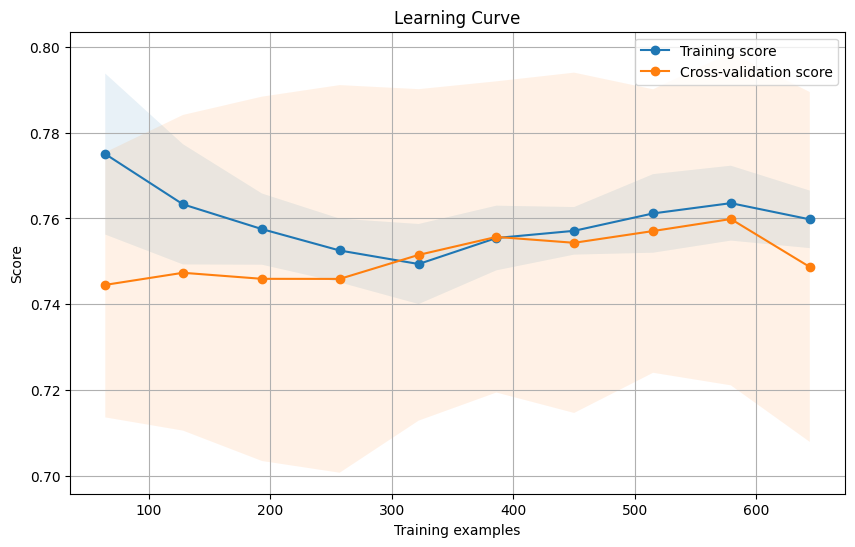

In [53]:
# Learning curve for model with 80% accuracy, randomstate=883
plot_learning_curve(logistic_regression_model, X_train, y_train)

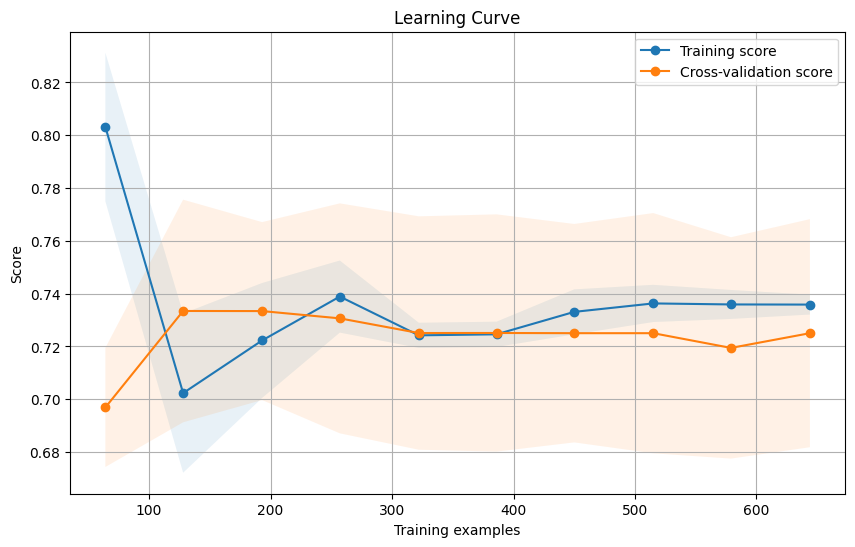

In [54]:
# Learning curve for model with 85% accuracy
plot_learning_curve(logistic_regression_model_best, X_train_best, y_train_best)

In [55]:
logistic_regression_model_10 = LogisticRegression(random_state=42)

# Training
X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(X_scaled, y, test_size=0.2, random_state= 10)
logistic_regression_model_10.fit(X_train_10, y_train_10)

# Model caracteristics
print("Model coefficients:", logistic_regression_model_10.coef_)
print("Model intercept:", logistic_regression_model_10.intercept_)

# Predictions
y_pred_10 = logistic_regression_model_10.predict(X_test_10)
LR_accuracy_10 = accuracy_score(y_test_10, y_pred_10)
print("Prediction Dimension:", y_pred_10.shape, '\nAccuracy:', LR_accuracy_10)

Model coefficients: [[ 0.08038148 -0.03837248 -0.13735659  0.01210189 -0.1173487  -0.07164298
  -1.45788877]]
Model intercept: [-0.61432683]
Prediction Dimension: (179,) 
Accuracy: 0.7988826815642458


In [64]:
Kfold_CV(k=5, X=X_train_10, y=y_train_10, model=logistic_regression_model_10)

(716, 7) (716,)
Average Training Score: 0.7447613468555877
Average Validation Score: 0.7374514374514375
The model is overfitting.


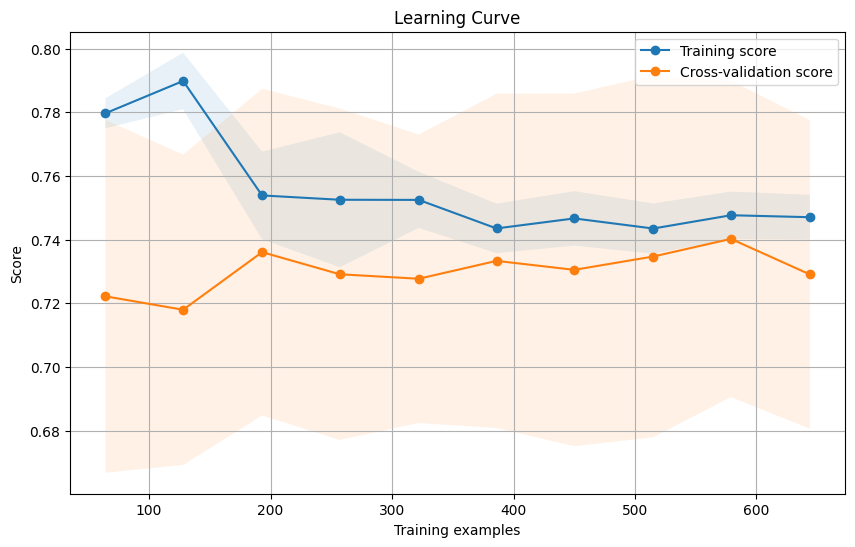

In [85]:
# Learning curve for model with 80% accuracy, randomstate=10
plot_learning_curve(logistic_regression_model_10, X_train_10, y_train_10)

We have achieved more 80% of performance as requested, and more !

And now let's see what we got for our initial dataset

In [56]:
# Using manager's requirements
y_pred1 = logistic_regression_model.predict(X_scaled)
y_pred1.shape

(895,)

In [57]:
# For best accuracy
y_pred2 = logistic_regression_model_best.predict(X_scaled)
y_pred2.shape

(895,)

In [58]:
y_pred3 = logistic_regression_model_10.predict(X_scaled)
y_pred3.shape

(895,)

In [59]:
y_pred4 = random_forest_model.predict(X_scaled)
y_pred4.shape

(895,)

In [60]:
predictions_df = site_traffic_df_cleaned.copy()
predictions_df['required_predictions'] = label_encoder.inverse_transform(y_pred1)
predictions_df['best_predictions'] = label_encoder.inverse_transform(y_pred2)
#predictions_df['final_predictions'] = label_encoder.inverse_transform(y_pred3)
predictions_df['RF_predictions'] = label_encoder.inverse_transform(y_pred4)
predictions_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
531,532,133.70,50.22,0.10,32.71,Chicken,6,unknown,2,1,unknown,unknown,unknown
3,4,97.03,30.56,38.63,0.02,Beverages,4,High,0,0,unknown,unknown,High
737,738,686.84,17.72,95.75,1.64,Dessert,4,High,3,0,High,unknown,High
849,850,0.64,75.64,3.26,6.95,Breakfast,1,unknown,1,1,unknown,unknown,High
308,309,73.91,35.05,2.09,14.68,Vegetable,6,High,9,0,High,High,High
529,530,448.59,181.98,36.47,12.03,One Dish Meal,6,High,6,0,High,High,High
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High,6,0,High,High,High
797,798,94.44,13.41,2.48,3.24,Potato,4,High,8,0,High,High,High
403,404,126.96,19.11,18.17,0.18,Beverages,4,unknown,0,1,unknown,unknown,unknown
456,457,286.70,29.92,2.80,28.07,Breakfast,4,High,1,0,unknown,unknown,High


In [61]:
unknown_traffic_df = predictions_df[predictions_df['high_traffic']=='unknown']
unknown_traffic_df.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
50,51,293.36,19.16,9.40,1.32,Pork,2,unknown,7,1,High,High,High
601,602,565.23,91.95,13.44,3.21,Potato,1,unknown,8,1,High,High,High
71,72,2508.47,18.11,10.60,84.23,Chicken,4,unknown,2,1,unknown,unknown,unknown
566,567,1635.46,35.00,9.39,42.13,Pork,1,unknown,7,1,High,High,unknown
307,308,406.05,128.22,18.58,15.06,Breakfast,2,unknown,1,1,unknown,unknown,unknown
431,432,402.00,47.57,0.36,0.02,Beverages,6,unknown,0,1,unknown,unknown,unknown
597,598,212.40,19.20,2.25,23.78,Breakfast,2,unknown,1,1,unknown,unknown,unknown
551,552,238.30,0.21,9.43,2.64,Meat,2,unknown,5,1,High,High,High
42,43,576.89,4.79,20.92,4.29,One Dish Meal,2,unknown,6,1,High,High,High
470,471,1272.10,3.13,0.73,25.44,Chicken,1,unknown,2,1,unknown,unknown,unknown


In [62]:
high_traffic_df1 = unknown_traffic_df[unknown_traffic_df['required_predictions']=='High']
high_traffic_df2 = unknown_traffic_df[unknown_traffic_df['best_predictions']=='High']
#high_traffic_df3 = unknown_traffic_df[unknown_traffic_df['final_predictions']=='High']
high_traffic_df4 = unknown_traffic_df[unknown_traffic_df['RF_predictions']=='High']

In [64]:
high_traffic_df1.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
757,758,853.22,24.80,0.90,14.10,Lunch/Snacks,4,unknown,4,1,High,High,High
302,303,889.25,13.44,1.61,2.58,One Dish Meal,2,unknown,6,1,High,High,unknown
735,736,513.75,65.87,18.63,18.39,Lunch/Snacks,4,unknown,4,1,High,High,unknown
601,602,565.23,91.95,13.44,3.21,Potato,1,unknown,8,1,High,High,High
190,191,1330.30,1.63,6.39,70.31,Meat,4,unknown,5,1,High,High,unknown
239,240,593.56,243.20,0.60,2.56,Chicken,2,unknown,2,1,High,High,unknown
860,861,207.96,16.55,76.11,1.19,Dessert,4,unknown,3,1,High,unknown,unknown
178,179,336.52,1.05,1.89,5.22,Lunch/Snacks,2,unknown,4,1,High,High,unknown
477,478,28.33,66.30,0.77,10.13,Lunch/Snacks,6,unknown,4,1,High,High,unknown
177,178,114.00,113.65,3.10,26.36,Lunch/Snacks,4,unknown,4,1,High,High,High


In [65]:
high_traffic_df2.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
751,752,32.29,133.90,14.35,0.74,Dessert,6,unknown,3,1,High,High,High
35,36,796.89,29.10,9.63,2.28,Lunch/Snacks,2,unknown,4,1,High,High,High
183,184,61.80,6.28,0.72,15.46,Vegetable,4,unknown,9,1,High,High,High
342,343,111.10,37.55,6.60,239.57,Lunch/Snacks,2,unknown,4,1,High,High,High
879,880,190.33,22.62,0.51,11.92,Meat,4,unknown,5,1,High,High,High
480,481,394.55,50.96,2.45,66.40,Chicken,1,unknown,2,1,unknown,High,unknown
452,453,361.17,21.52,3.38,19.22,Lunch/Snacks,6,unknown,4,1,High,High,High
758,759,253.63,12.99,5.75,9.50,Potato,1,unknown,8,1,High,High,unknown
639,640,1580.48,16.20,8.67,10.55,Meat,4,unknown,5,1,High,High,unknown
618,619,368.09,6.70,0.68,8.16,Lunch/Snacks,1,unknown,4,1,High,High,High


In [92]:
# high_traffic_df3

NameError: name 'high_traffic_df3' is not defined

In [67]:
high_traffic_df4.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions
751,752,32.29,133.90,14.35,0.74,Dessert,6,unknown,3,1,High,High,High
601,602,565.23,91.95,13.44,3.21,Potato,1,unknown,8,1,High,High,High
365,366,516.76,13.59,2.96,50.19,Chicken,4,unknown,2,1,unknown,unknown,High
35,36,796.89,29.10,9.63,2.28,Lunch/Snacks,2,unknown,4,1,High,High,High
426,427,187.41,19.12,86.97,4.49,Dessert,6,unknown,3,1,High,unknown,High
940,941,1337.50,49.91,0.76,57.90,Chicken,4,unknown,2,1,unknown,unknown,High
883,884,343.26,85.06,1.58,19.57,Lunch/Snacks,2,unknown,4,1,High,High,High
942,943,1161.00,5.31,22.39,44.22,Lunch/Snacks,2,unknown,4,1,High,High,High
293,294,410.92,23.17,1.04,19.34,Meat,6,unknown,5,1,High,High,High
145,146,258.16,7.53,1.20,40.32,Chicken,6,unknown,2,1,unknown,unknown,High


It seems that at best accuracy we're able to eliminate 2 'wrong' predictions, not bad but we may think of tunning the model to produce more 'High' traffic because 94 predictions among 360 might not be very satisfying fot the manager :). Note that if at this stage the model was at the best possible performance we can say that the rest of the unknown states are simply the ones that correspond to 'Not High' traffic.

In [68]:
# Prediction Ratio
R1 = len(high_traffic_df1)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
R1

27.61394101876676

In [69]:
# Prediction Ratio
R2 = len(high_traffic_df2)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
R2

26.273458445040216

In [71]:
# R3 = len(high_traffic_df3)/len(site_traffic_df[site_traffic_df['high_traffic']=='unknown'])*100
# R3

In [72]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_req = confusion_matrix(y_test, y_pred_req)
print("Confusion Matrix:")
print(conf_matrix_req)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_req))

Confusion Matrix:
[[85 21]
 [21 52]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       106
           1       0.71      0.71      0.71        73

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In [73]:
conf_matrix_best = confusion_matrix(y_test_best, y_pred_best)
print("Confusion Matrix:")
print(conf_matrix_best)

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test_best, y_pred_best))

Confusion Matrix:
[[86 12]
 [14 67]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        98
           1       0.85      0.83      0.84        81

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179



- Accuracy: The second model (85%) outperforms the first model (80%) in terms of overall accuracy, indicating that it makes correct predictions for a higher proportion of instances.
- Precision: Both models have the same precision (86%), indicating that they have a similar ability to correctly identify positive instances (e.g., instances predicted as "high traffic") among all instances predicted as positive.
- Recall: The second model (88%) has a higher recall than the first model (82%), indicating that it captures a higher proportion of actual positive instances among all positive instances in the dataset.
- F1-score: The F1-score, which is the harmonic mean of precision and recall, is slightly higher for the second model (87%) compared to the first model (84%). This suggests that the second model achieves a better balance between precision and recall.
- ROC-AUC: The second model has a higher ROC-AUC score (0.89) than the first model (0.87), indicating better performance in terms of the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity).
- Confusion Matrix: The confusion matrices provide detailed information about the distribution of correct and incorrect predictions for each class. In both confusion matrices, the diagonal elements represent the number of correct predictions (true positives and true negatives), while the off-diagonal elements represent the number of incorrect predictions (false positives and false negatives).

### 3.2. Model Fine Tuning

BUT the most accurate model doesn't provide better results, this might be due to imbalanced calss weights.

In [74]:
from sklearn.utils.class_weight import compute_class_weight

# Computing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_best), y=y_train_best)

class_weight = dict(zip(np.unique(y_train_best), class_weights))

# Train a logistic regression model with class weights
logreg_model_balanced = LogisticRegression(class_weight=class_weight)
logreg_model_balanced.fit(X_train_best, y_train_best)

# Make predictions on the test set
y_pred_best_balanced = logreg_model_balanced.predict(X_scaled)
predictions_df['balanced_predictions'] = label_encoder.inverse_transform(y_pred_best_balanced)
unknown_traffic_df_balanced = predictions_df[predictions_df['high_traffic']=='unknown']

In [75]:
high_traffic_df_balanced = unknown_traffic_df_balanced[unknown_traffic_df_balanced['best_predictions']=='High']
high_traffic_df_balanced.sample(10)

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,category_encoded,traffic_encoded,required_predictions,best_predictions,RF_predictions,balanced_predictions
441,442,538.88,6.84,6.95,43.91,One Dish Meal,2,unknown,6,1,High,High,unknown,High
190,191,1330.30,1.63,6.39,70.31,Meat,4,unknown,5,1,High,High,unknown,High
662,663,715.14,20.37,3.27,2.47,Dessert,1,unknown,3,1,unknown,High,unknown,unknown
584,585,373.30,113.99,3.05,7.32,One Dish Meal,2,unknown,6,1,High,High,unknown,High
591,592,748.98,38.66,2.53,32.23,Pork,6,unknown,7,1,High,High,unknown,High
469,470,751.18,163.33,13.71,29.39,Lunch/Snacks,6,unknown,4,1,High,High,unknown,High
69,70,799.39,23.14,3.33,19.75,One Dish Meal,1,unknown,6,1,High,High,High,High
353,354,1045.21,5.12,1.79,70.69,Meat,4,unknown,5,1,High,High,High,High
580,581,467.47,55.60,2.24,51.15,Meat,6,unknown,5,1,High,High,unknown,High
769,770,573.69,9.55,5.19,7.83,Meat,4,unknown,5,1,High,High,High,High


In [76]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l1', 'l2'],                # Regularization penalty
    'solver': ['liblinear', 'saga']         # Algorithm to use in optimization problem
}

grid_search = GridSearchCV(estimator=logistic_regression_model, param_grid=param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Train the SVM classifier with the best hyperparameters
LR_tunned = LogisticRegression(**best_params)
LR_tunned.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tuned = LR_tunned.predict(X_test)

# Evaluate performance
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print('Accuracy tunned:', accuracy_tuned)

Best Hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy tunned: 0.7653631284916201


In [77]:
regularized_LR = LogisticRegression(penalty='l2', C=0.1)
regularized_LR.fit(X_train, y_train)
y_pred_regularized = regularized_LR.predict(X_test)
accuracy_regularized = accuracy_score(y_pred_regularized, y_test)
accuracy_regularized

0.770949720670391

L2 regularazation seems to be working a bit but not enough since we seek a 80% accuracy.

#### 3.2.1. Using Ensemble Methods for fine tunning

1. Bagging (Bootstrap Aggregating):

In [81]:
from sklearn.ensemble import BaggingClassifier

# Bagging with logistic_regression_model_req
bagging_req = BaggingClassifier(base_estimator=logistic_regression_model, n_estimators=10, random_state=42)
bagging_req.fit(X_train, y_train)
y_pred_bagging_req = bagging_req.predict(X_test)

# Bagging with logistic_regression_model_best
bagging_best = BaggingClassifier(base_estimator=logistic_regression_model_best, n_estimators=10, random_state=42)
bagging_best.fit(X_train_best, y_train_best)
y_pred_bagging_best = bagging_best.predict(X_test_best)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


2. Boosting

In [82]:
from sklearn.ensemble import AdaBoostClassifier

# Boosting with logistic_regression_model_req
adaboost_req = AdaBoostClassifier(base_estimator=logistic_regression_model, n_estimators=50, random_state=42)
adaboost_req.fit(X_train, y_train)
y_pred_adaboost_req = adaboost_req.predict(X_test)

# Boosting with logistic_regression_model_best
adaboost_best = AdaBoostClassifier(base_estimator=logistic_regression_model_best, n_estimators=50, random_state=42)
adaboost_best.fit(X_train_best, y_train_best)
y_pred_adaboost_best = adaboost_best.predict(X_test_best)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


3. Stacking

In [83]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define meta-estimator (logistic regression)
meta_estimator = LogisticRegression()

# Stacking with logistic_regression_model_req and logistic_regression_model_best
estimators = [('req', logistic_regression_model), ('best', logistic_regression_model_best)]
stacking = StackingClassifier(estimators=estimators, final_estimator=meta_estimator)

# Fit stacking classifier with corresponding subsets of training data
stacking.fit(X_train, y_train)  # Use X_train_req and y_train_req for logistic_regression_model_req
y_pred_stacking = stacking.predict(X_test_best)
stacking_accuracy = accuracy_score(y_pred_stacking, y_test)
stacking_accuracy

0.5195530726256983

Okay, it's just getting worse.

In [84]:
# logistic regression model fitting
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()

# summary of logistic regression results
print(logit_result.summary())

Optimization terminated successfully.
         Current function value: 0.481892
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:        traffic_encoded   No. Observations:                  716
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            7
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.2843
Time:                        01:22:35   Log-Likelihood:                -345.03
converged:                       True   LL-Null:                       -482.12
Covariance Type:            nonrobust   LLR p-value:                 1.968e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7165      0.105     -6.832      0.000      -0.922      -0.511
x1             0.0378      0.

- The value of the loss function is 0.5 (relatively small), meaning that the model acheived a good fit for the data.
- About 25% of the variance of the dependent variable (high traffic) is explained by the independent variables (recipes).
- The LLR p-value is extremly low so the model is statistically significant.